In [1]:
import os
os.chdir("..")
print("Current Directory:", os.getcwd())

Current Directory: /workspace/iscat


In [2]:
from src.inference.inference import SegInference
import torch
import numpy as np
import matplotlib.pyplot as plt
DEVICE = "cuda:7"

In [3]:
experiment_path = "experiments/runs/U_Net_Brightfield_2025-01-25_16-50-24"
seginf = SegInference(experiment_path,DEVICE)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [4]:
from src.data_processing.dataset import iScatDataset
h5py_path = 'dataset/brightfield.hdf5'
dataset = iScatDataset(h5py_path,[0,1],normalize="zscore")

In [165]:
image,gt_mask = dataset[7]
image = image.to(DEVICE)

In [166]:
pred = seginf.model(image.unsqueeze(0))
pred = torch.argmax(pred,axis=1)
pred = pred[0].cpu().numpy()
pred = pred.astype(np.uint8)

In [158]:
import cv2
import numpy as np

def watershed_segmentation(binary_mask):
    """
    Apply watershed algorithm to binary mask for instance segmentation
    
    Args:
        binary_mask (np.ndarray): Binary mask of particles
    
    Returns:
        np.ndarray: Labeled instance segmentation mask
    """
    # Find connected components (markers)
    num_labels, markers = cv2.connectedComponents(binary_mask)
    
    # Ensure background is labeled 0
    markers = markers + 1
    markers[binary_mask == 0] = 0
    
    # Apply distance transform to get marker seeds
    dist_transform = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 5)
    
    # Threshold distance transform to create marker seeds
    _, sure_fg = cv2.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    
    # Apply watershed
    binary_mask_3channel = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
    instances = cv2.watershed(binary_mask_3channel, markers)
    
    return instances

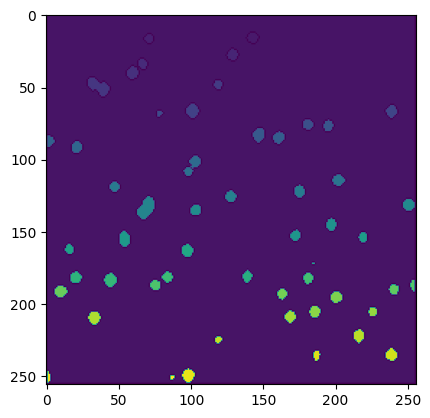

In [82]:
out =  watershed_segmentation(pred*255)
plt.imshow(out)

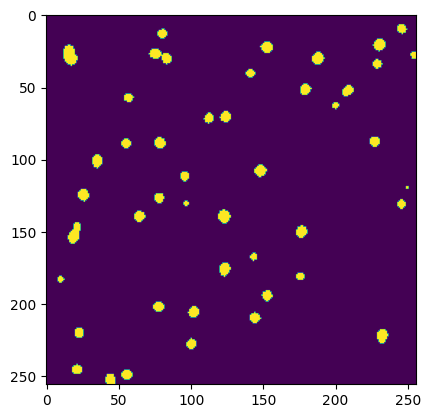

In [167]:
plt.imshow(pred)

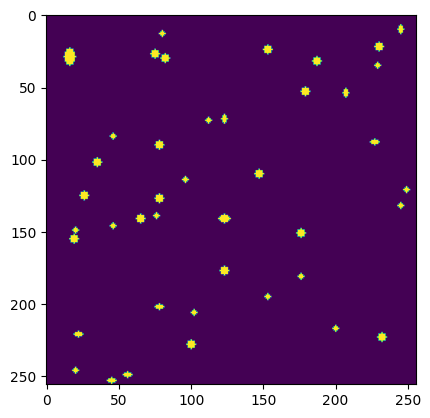

In [168]:
plt.imshow(gt_mask)

In [198]:
import cv2
import numpy as np

def watershed_instance_segmentation(binary_mask):
    """
    Perform watershed segmentation on a binary mask
    
    Args:
        binary_mask (np.ndarray): Binary mask (0,1)
    
    Returns:
        np.ndarray: Instance segmentation mask (0, 1, 2, 3...)
    """
    # Convert to 255 binary image
    thresh = (binary_mask * 255).astype(np.uint8)
    
    # Morphological opening to remove small noise
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Sure background
    sure_bg = cv2.dilate(opening, kernel, iterations=100)
    
    # Distance transform for foreground
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    
    # Foreground threshold (adjustable)
    ret, sure_fg = cv2.threshold(dist_transform, 0.1*dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    
    # Unknown region
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Connected components markers
    ret, markers = cv2.connectedComponents(sure_fg)
    
    # Adjust markers
    markers = markers + 10
    markers[unknown == 255] = 0
    
    # Fake 3-channel image for watershed
    fake_rgb = np.zeros((*binary_mask.shape, 3), dtype=np.uint8)
    fake_rgb[:,:,0] = thresh
    
    # Watershed
    markers = cv2.watershed(fake_rgb, markers)
    
    return markers

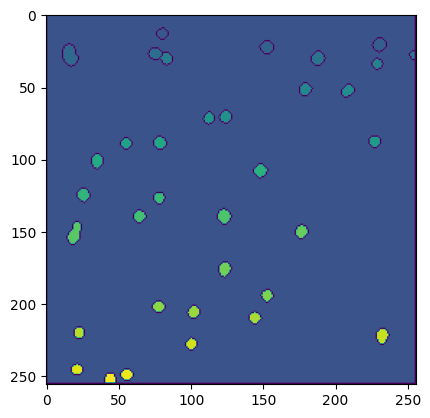

In [199]:
out = watershed_instance_segmentation(pred)
plt.imshow(out)

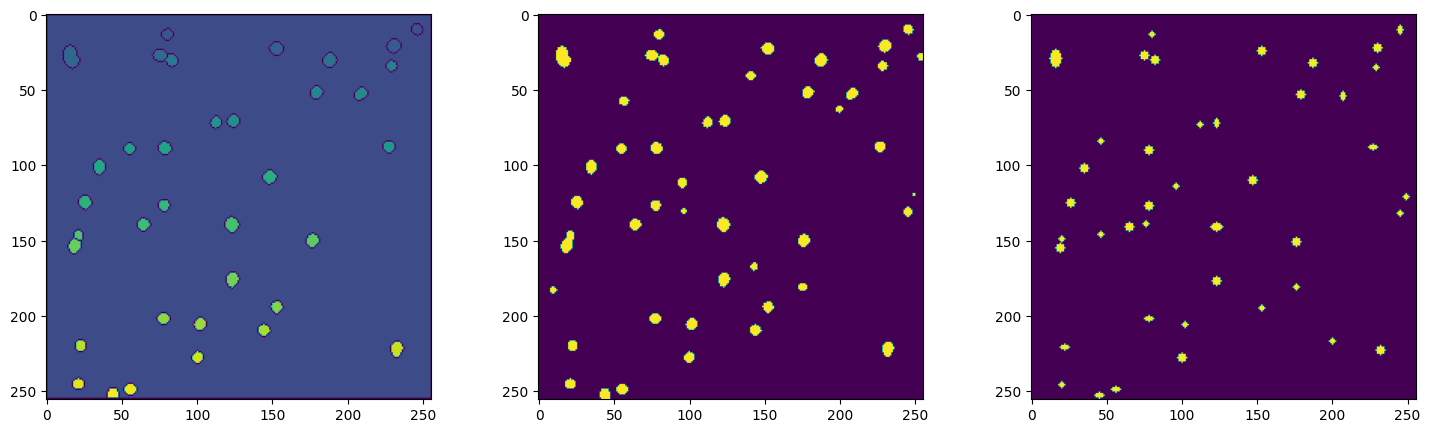

In [192]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.imshow(out)
ax3.imshow(gt_mask)
ax2.imshow(pred)

In [210]:
def generate_boundary_mask(mask):
    mask = np.uint8(mask * 255)
    sobelx = cv2.Sobel(mask, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(mask, cv2.CV_64F, 0, 1, ksize=3)
    boundary_mask = np.sqrt(sobelx**2 + sobely**2)
    boundary_mask = (boundary_mask - boundary_mask.min()) / (boundary_mask.max() - boundary_mask.min() + 1e-8)
    return boundary_mask

In [220]:
a=np.ones((256,256))
f=generate_boundary_mask(gt_mask)

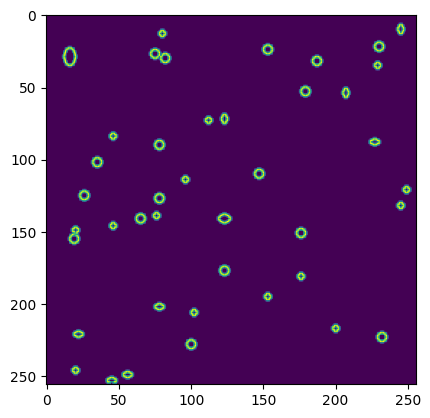

In [221]:
plt.imshow(f)

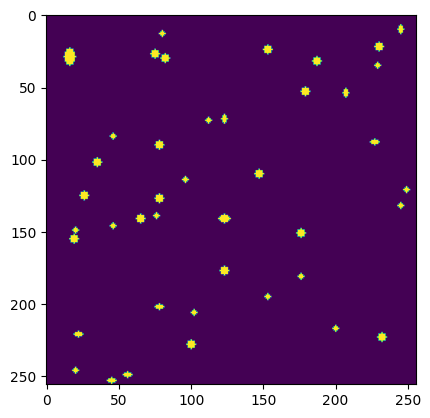

In [222]:
plt.imshow(gt_mask)

In [28]:
from src.data_processing.dataset import iScatDataset2

h5py_path = 'dataset/brightfield.hdf5'
experiment_path = "experiments/runs/U_Net_Brightfield_2025-01-25_16-50-24"
seginf = SegInference(experiment_path,DEVICE)
d = iScatDataset2(h5py_path,[0,1],normalize="zscore",boundary_mask=True)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [66]:
from src.models.Unet import UNetBoundaryAware
image,m,b = d[12]
model = UNetBoundaryAware(32,2)
model_path = "experiments/runs/UNetBoundaryAware_Brightfield_2025-01-27_02-38-04/best_model.pth"
checkpoint = torch.load(model_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
model.to(DEVICE)
model.eval()
with torch.no_grad():
    image = image.to(DEVICE).unsqueeze(0)
    pred_m_old = seginf.model(image)
    pred_m,pred_b = model(image)
    pred_m_old = torch.argmax(pred_m_old .squeeze(0),axis=0).cpu().numpy()
    pred_m = torch.argmax(pred_m.squeeze(0),axis=0).cpu().numpy().astype(np.uint8)
    pred_b = pred_b.squeeze(0).cpu().numpy()
    image = image.squeeze(0).cpu().numpy()

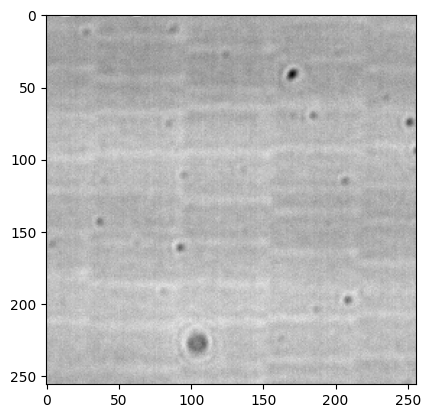

In [24]:
plt.imshow(image[0],cmap="gray")

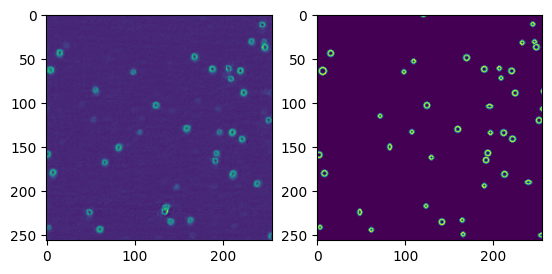

In [132]:
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(pred_b)
ax2.imshow(b)

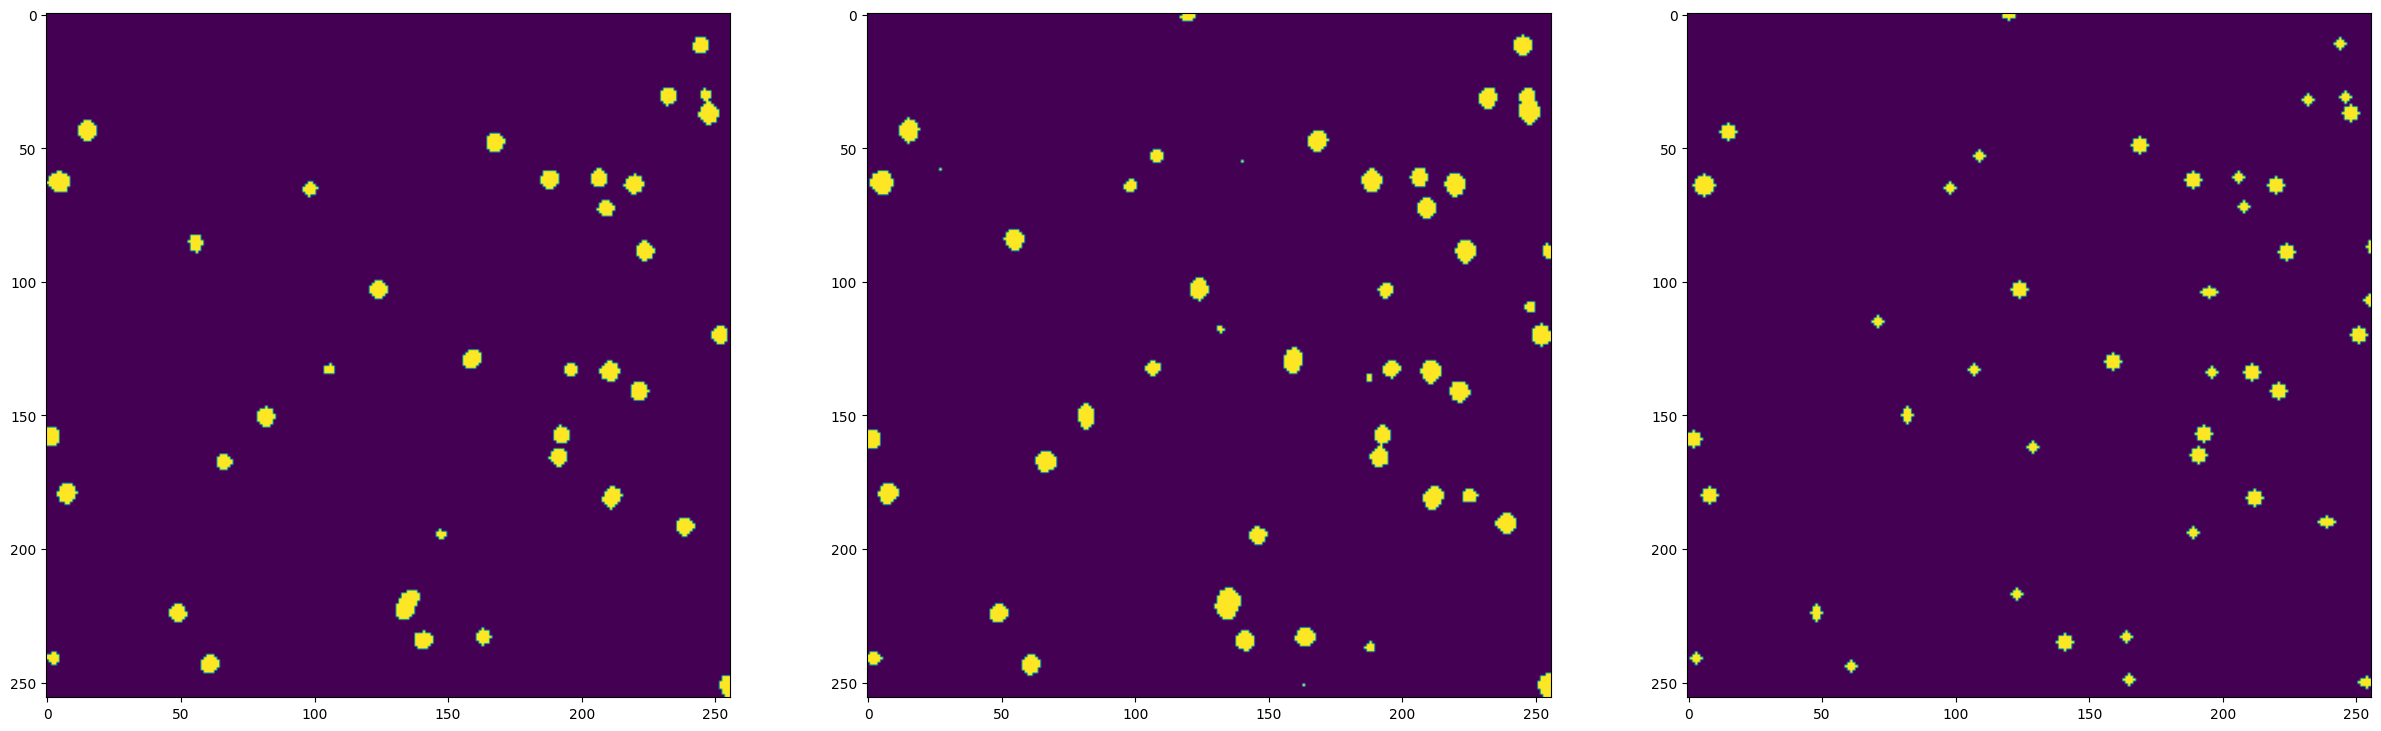

In [106]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(30,15))
ax1.imshow(pred_m)
ax2.imshow (pred_m_old)
ax3.imshow(m)
plt.show()

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

distance = ndi.distance_transform_edt(pred_m)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=pred_m)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=pred_m)


In [177]:
from skimage.measure import label
import numpy as np

def get_instance_labels(image):
    labeled_image = label(image)
    instance_labels = np.unique(labeled_image)
    instance_labels = instance_labels[instance_labels > 0]  
    return instance_labels.tolist()
print(f"{len(get_instance_labels(pred_m))} predicted instances")
print(f"{len(get_instance_labels(labels))} predicted instances with watershed")
print(f"{len(get_instance_labels(m))} gt instances")

36 predicted instances
39 predicted instances with watershed
43 gt instances


In [198]:
np.unique(labels,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39], dtype=int32),
 array([64253,    31,    33,    15,    48,    44,    40,    34,    40,
           52,    40,    22,    30,    28,    39,    37,    34,    41,
           13,    21,    44,    39,    40,    33,    33,    35,    28,
           44,    29,    14,    36,    11,    37,    35,    36,    26,
           38,    18,    39,    26]))

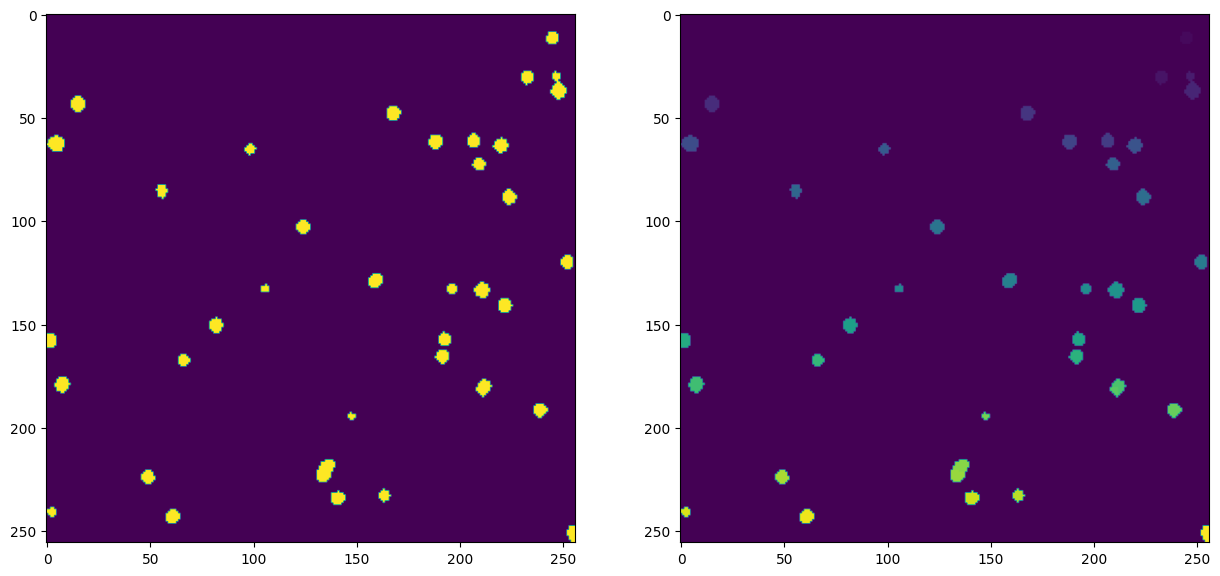

In [168]:
# plt.figure(figsize=(30,30))
# plt.imshow(out)
# plt.show()
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(15,15))
ax1.imshow(pred_m)
ax2.imshow (labels)
plt.show()

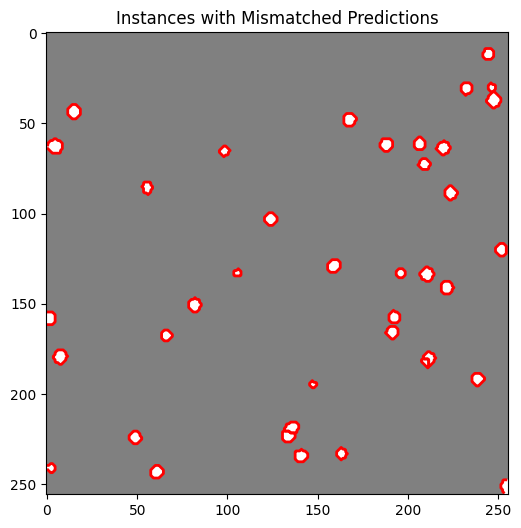

In [202]:
import numpy as np
import matplotlib.pyplot as plt
instance_mask = labels
semantic_mask = pred_m
unique_instances = np.unique(instance_mask)
unique_instances = unique_instances[unique_instances != 0]  # exclude background (0)

# Step 2: Initialize a figure for plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Step 3: Plot the semantic mask
ax.imshow(semantic_mask, cmap='gray', alpha=0.5)  # Light transparency for background

# Step 4: Compare and plot instances that don't match the semantic mask
for instance in unique_instances:
    # Create a binary mask for the current instance
    instance_region = (instance_mask == instance)
    
    # Check if the instance matches the semantic mask (i.e., predicted region should be 1)
    # The semantic mask should have 1 where an object exists, so check where they differ
    semantic_instance_region = (semantic_mask == 1) & instance_region
    
    if np.any(semantic_instance_region):  # If there's a mismatch, highlight it
        ax.contour(instance_region, colors='red', linewidths=2)

plt.title("Instances with Mismatched Predictions")
plt.show()
